# **Import Library dan Install Dependensi**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow -q

In [4]:
!pip install mtcnn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00


In [5]:
# Library untuk manipulasi data dan analisis numerik
import pandas as pd
import numpy as np

# Library untuk plotting dan visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pengolahan dan manipulasi gambar
import cv2
from PIL import Image

# Library untuk operasi sistem, manipulasi file dan direktori, serta handling file zip
import zipfile
import os
import shutil
import random
from uuid import uuid4 # Untuk membuat identifier unik

# Library untuk augmentasi dan preprocessing gambar pada deep learning dengan Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Library untuk mengabaikan peringatan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk progress bar saat iterasi panjang
from tqdm import tqdm

# Library untuk deteksi wajah dengan MTCNN (Multi-task Cascaded Convolutional Networks)
from mtcnn.mtcnn import MTCNN

# Library untuk clustering, contoh K-Means clustering
from sklearn.cluster import KMeans

# **Load Dataset**

In [5]:
# Path ke file ZIP
zip_path = "./drive/MyDrive/Hijabist-Drive/Skin-tone/Dataset/hijabist-skin-tone.zip"
extract_path = "./skin-tone-datasets"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  print(f"Mengekstrak {zip_path} ke {extract_path}...")
  zip_ref.extractall(extract_path)
  print("Ekstraksi selesai.")

Mengekstrak ./drive/MyDrive/Hijabist-Drive/Skin-tone/Dataset/hijabist-skin-tone.zip ke ./skin-tone-datasets...
Ekstraksi selesai.


# **Exploratory Data Analysis (EDA)**

In [6]:
# Cek isi folder
datasets = './skin-tone-datasets'
print("\nIsi dalam dataset:")
print(os.listdir(datasets))


Isi dalam dataset:
['dark', 'light', 'mid-light', 'mid-dark']


Distribusi jumlah gambar per kelas: {'dark': 539, 'light': 668, 'mid-light': 1089, 'mid-dark': 650}


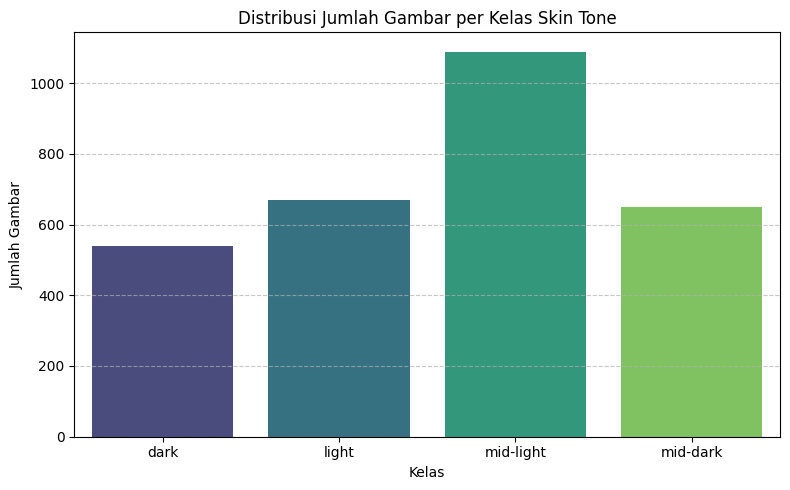

In [7]:
def count_images_per_class(dataset_path):
    """
    Mengembalikan dictionary jumlah gambar (.jpg/.png/.jpeg) per kelas dari dataset.
    """
    return {
        class_name: len([
            f for f in os.listdir(os.path.join(dataset_path, class_name))
            if os.path.isfile(os.path.join(dataset_path, class_name, f)) and
               f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for class_name in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, class_name))
    }

def plot_class_distribution(class_counts, title='Distribusi Jumlah Gambar per Kelas'):
    """
    Membuat barplot visualisasi distribusi jumlah gambar per kelas.
    """
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

class_counts = count_images_per_class(datasets)
print("Distribusi jumlah gambar per kelas:", class_counts)

# Visualisasi distribusi
plot_class_distribution(class_counts, title='Distribusi Jumlah Gambar per Kelas Skin Tone')

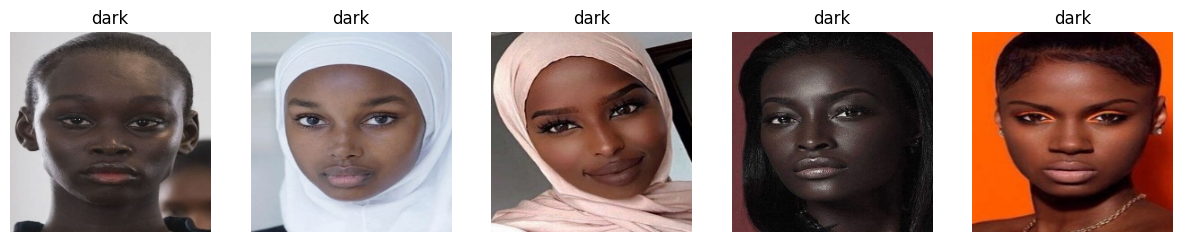

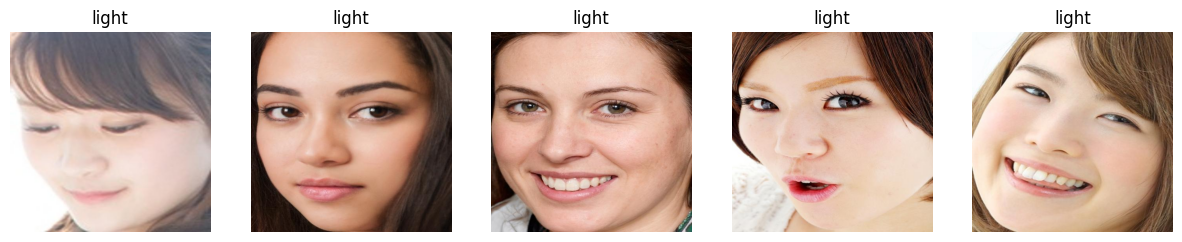

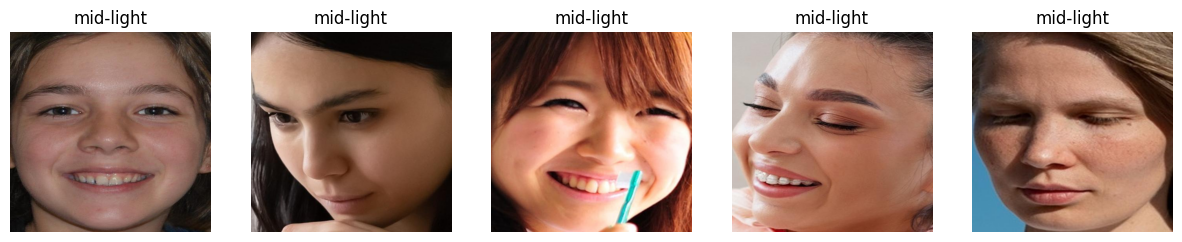

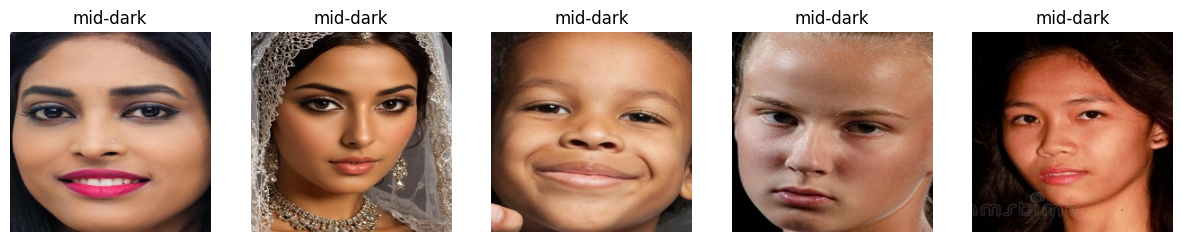

In [8]:
# Visualisasi contoh gambar dari setiap kelas
def show_samples(datasets, class_name, n=5):
    """
    Menampilkan n gambar pertama dari kelas tertentu.
    """
    folder = os.path.join(datasets, class_name)
    images = os.listdir(folder)[:n]  # Ambil n file gambar pertama dalam folder
    plt.figure(figsize=(15, 3))

    for i, img_file in enumerate(images):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Loop untuk menampilkan contoh gambar dari setiap kelas yang ada di dalam folder dataset
for skin_class in os.listdir(datasets):
    show_samples(datasets, skin_class)

In [9]:
def check_image_sizes(dataset_path):
    """
    Mengumpulkan ukuran (width, height) semua gambar dalam dataset
    dan menampilkan statistik deskriptif ukuran gambar.
    """
    sizes = []  # List untuk menyimpan ukuran semua gambar

    for skin_class in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, skin_class)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)

            try:
                # Buka gambar dan ambil ukuran (width, height)
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                # Tangani error jika file rusak atau bukan gambar
                print(f"Error membuka gambar {img_path}: {e}")

    sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])
    print(sizes_df.describe())

    return sizes_df

# Jalankan fungsi untuk mengecek ukuran semua gambar dalam dataset
sizes_df = check_image_sizes(datasets)

             Width       Height
count  2946.000000  2946.000000
mean    420.301426   420.301426
std     134.188946   134.188946
min     224.000000   224.000000
25%     224.000000   224.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max     512.000000   512.000000


In [10]:
# Distribusi Warna Dominan
def get_dominant_color(img_path, k=3):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img)
    return kmeans.cluster_centers_.astype(int)

# Contoh ambil warna dari 1 gambar di tiap kelas
for skin_class in os.listdir(datasets):
    sample_img = os.listdir(os.path.join(datasets, skin_class))[0]
    color = get_dominant_color(os.path.join(datasets, skin_class, sample_img))
    print(f"{skin_class} dominant color:", color)

dark dominant color: [[ 60  49  47]
 [206 205 206]
 [106  89  84]]
light dominant color: [[111 101 106]
 [239 219 211]
 [192 162 152]]
mid-light dominant color: [[115  82  70]
 [159 118 107]
 [ 39  30  24]]
mid-dark dominant color: [[151  98  84]
 [213 162 135]
 [ 36  30  34]]


Insight:
1. Ukuran gambar perlu di resize dan disamakan ke 224*224 agar cocok ke pretrained model
2. Dominan color dalam satu kelas masih terdapat perbedaan mencolok sepertinya dipengaruhi warna rambut dan background maka perlu di cropping agar fokus di bagian wajah.
3. distribusi data masih belum seimbang sehingga perlu dilakukan undersampling dan augmentasi untuk menyamakan kelas. Selain itu mungkin augmentasi diperlukan untuk setiap kelas untuk robustness model

# **Data Preparation**



## **Cropping Face**

In [11]:
def crop_faces(source_dir, output_dir):
    detector = MTCNN()  # Inisialisasi detektor wajah dari MTCNN
    total_cropped = 0  # Hitung jumlah gambar yang berhasil di-crop
    failed = []        # Simpan path gambar yang gagal diproses

    print(f"Cropping faces (by keypoints) from {source_dir}...")

    # Loop setiap folder (kelas) dalam source_dir
    for class_name in os.listdir(source_dir):
        class_input_path = os.path.join(source_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)

        # Lewati jika bukan folder
        if not os.path.isdir(class_input_path):
            continue

        # Buat folder output jika belum ada
        os.makedirs(class_output_path, exist_ok=True)

        # Ambil semua file gambar
        image_files = [
            f for f in os.listdir(class_input_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        # Loop setiap gambar
        for img_name in tqdm(image_files, desc=f"Processing {class_name}"):
            input_path = os.path.join(class_input_path, img_name)
            output_path = os.path.join(class_output_path, img_name)

            try:
                # Baca gambar
                img = cv2.imread(input_path)
                if img is None:
                    raise ValueError("Image cannot be read")  # Error jika gambar rusak atau tidak bisa dibaca

                # Konversi ke RGB karena MTCNN menggunakan format RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Deteksi wajah
                faces = detector.detect_faces(img_rgb)
                if not faces:
                    raise ValueError("No faces detected")  # Error jika wajah tidak terdeteksi

                face = faces[0]  # Ambil wajah pertama yang terdeteksi
                keypoints = face['keypoints']

                # Ambil koordinat titik-titik kunci wajah
                leye = np.array(keypoints['left_eye'])
                reye = np.array(keypoints['right_eye'])
                nose = np.array(keypoints['nose'])
                mouth_left = np.array(keypoints['mouth_left'])
                mouth_right = np.array(keypoints['mouth_right'])

                # Hitung titik tengah wajah
                eye_center = (leye + reye) / 2
                mouth_center = (mouth_left + mouth_right) / 2
                center = (eye_center + mouth_center) / 2

                # Estimasi ukuran wajah berdasarkan jarak antara fitur
                face_height = int(np.linalg.norm(eye_center - mouth_center) * 2)
                face_width = int(np.linalg.norm(leye - reye) * 2.5)

                # Hitung koordinat crop dan clamp agar tidak keluar batas gambar
                x1 = max(0, int(center[0] - face_width // 2))
                y1 = max(0, int(center[1] - face_height // 2))
                x2 = min(img.shape[1], int(center[0] + face_width // 2))
                y2 = min(img.shape[0], int(center[1] + face_height // 2))

                # Lewati jika wajah terlalu kecil
                if (x2 - x1) < 60 or (y2 - y1) < 60:
                    raise ValueError("Crop size too small")

                # Crop wajah dan simpan
                face_crop = img[y1:y2, x1:x2]
                face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
                Image.fromarray(face_rgb).save(output_path)
                total_cropped += 1

            except Exception as e:
                # Simpan nama file yang gagal, dan salin gambar original ke output
                failed.append(input_path)
                shutil.copy2(input_path, output_path)

    # Ringkasan proses cropping
    print(f"\nCropping complete. Total cropped: {total_cropped}")
    if failed:
        print(f"Total failed (copied as-is): {len(failed)}")
        for f in failed:
            print(f"- {f}")

In [ ]:
source_dir = "./skin-tone-datasets"
output_dir = "./datasets_cropped"

crop_faces(source_dir, output_dir)

Cropping faces (by keypoints) from /content/skin-tone-datasets...


Processing mid-dark: 100%|██████████| 650/650 [02:19<00:00,  4.68it/s]


Cropping complete. Total cropped: 2921
Total deleted (face not detected or invalid): 25
- /content/skin-tone-datasets/light/9753060.jpg
- /content/skin-tone-datasets/light/7235975.jpg
- /content/skin-tone-datasets/light/8579256.jpg
- /content/skin-tone-datasets/light/10115790.jpg
- /content/skin-tone-datasets/light/1958315.jpg
- /content/skin-tone-datasets/light/9463886.jpg
- /content/skin-tone-datasets/mid-light/62018723.jpg
- /content/skin-tone-datasets/mid-light/106389668.jpg
- /content/skin-tone-datasets/mid-light/76196627.jpg
- /content/skin-tone-datasets/mid-light/37556088.jpg
- /content/skin-tone-datasets/mid-light/62712610.jpg
- /content/skin-tone-datasets/mid-light/108137621.jpg
- /content/skin-tone-datasets/mid-light/image_4498.jpg
- /content/skin-tone-datasets/mid-light/66035454.jpg
- /content/skin-tone-datasets/mid-light/27396280.jpg
- /content/skin-tone-datasets/mid-light/57634623.jpg
- /content/skin-tone-datasets/mid-light/95357578.jpg
- /content/skin-tone-datasets/mid-l

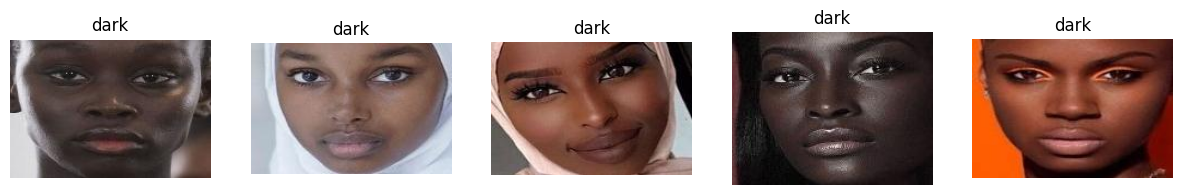

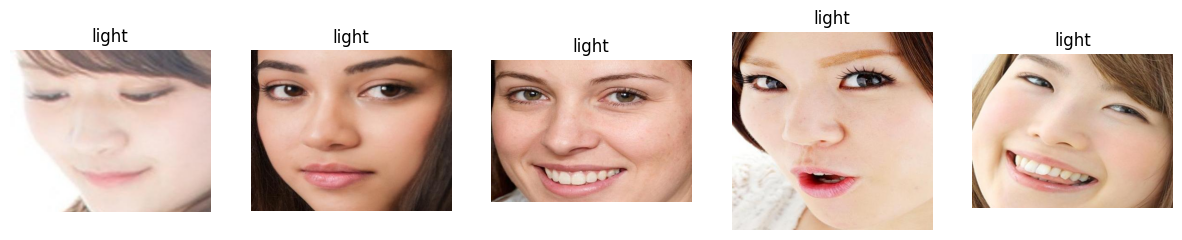

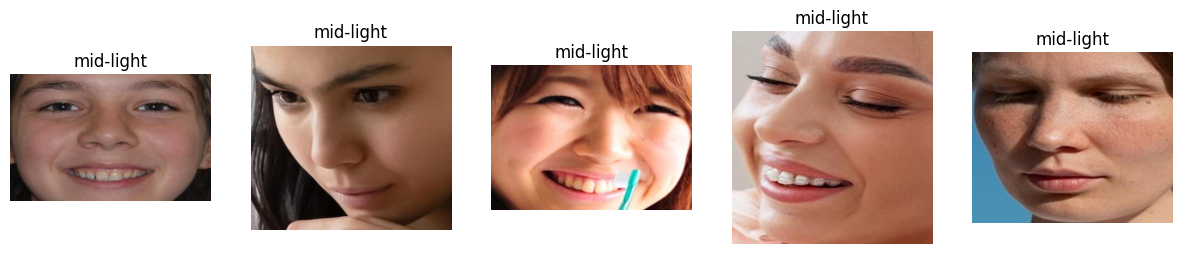

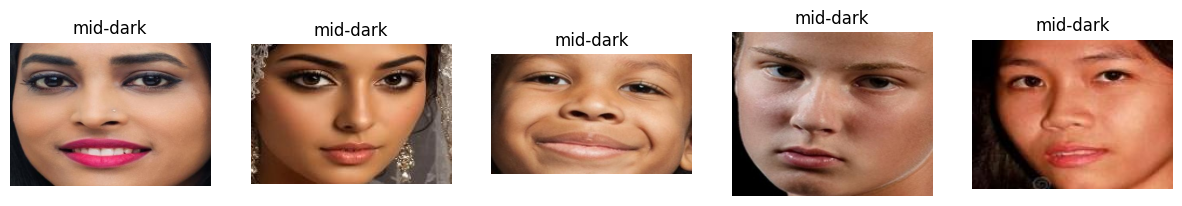

In [13]:
datasets_new = './datasets_cropped'

for skin_class in os.listdir(datasets_new):
    show_samples(datasets_new, skin_class)

In [14]:
class_counts = count_images_per_class(datasets_new)

# Cetak hasil
print("Distribusi jumlah gambar per kelas:", class_counts)

Distribusi jumlah gambar per kelas: {'dark': 539, 'light': 662, 'mid-light': 1070, 'mid-dark': 650}


## **Resize Image**

In [15]:
def resize_images(source_dir, output_dir, target_size=(224, 224)):
    """
    Resize semua gambar dari source_dir ke ukuran target dan simpan ke output_dir
    dengan struktur folder kelas yang sama.
    """
    print(f"\nResizing images from {source_dir} to {target_size} and saving to {output_dir}...")
    total_resized = 0
    errored_files = []

    # Buat direktori output utama jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name) # Path untuk kelas di folder output

        if not os.path.isdir(class_source_path):
            continue

        # Buat direktori kelas di dalam folder output jika belum ada
        os.makedirs(class_output_path, exist_ok=True)

        print(f"  Processing class: {class_name}")
        image_files = [
            f for f in os.listdir(class_source_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        for img_file in tqdm(image_files, desc=f"    Resizing {class_name}"):
            source_img_path = os.path.join(class_source_path, img_file)
            # output_img_path = os.path.join(class_output_path, img_file) # Path file output

            try:
                with Image.open(source_img_path) as img:
                    # Konversi ke RGB jika bukan
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Resize dengan antialiasing
                    try:
                        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                    except AttributeError:
                        img_resized = img.resize(target_size, Image.LANCZOS)

                    # Simpan ke folder output baru
                    output_img_path_jpg = os.path.splitext(os.path.join(class_output_path, img_file))[0] + ".jpg"
                    img_resized.save(output_img_path_jpg, format='JPEG', quality=95)

                    total_resized += 1

            except Exception as e:
                print(f"    Error resizing {source_img_path}: {e}")
                errored_files.append(source_img_path)

    print("\nImage resizing complete.")
    print(f"Total images resized: {total_resized}")
    if errored_files:
        print(f"Files with errors during resizing ({len(errored_files)}):")
        for f in errored_files:
            print(f"  - {f}")

In [16]:
resized_dataset = "./dataset-skin-tone_resized"

# Jalankan fungsi resize
resize_images(datasets_new, resized_dataset, target_size=(224, 224))


Resizing images from ./datasets_cropped to (224, 224) and saving to ./dataset-skin-tone_resized...
  Processing class: dark


    Resizing dark: 100%|██████████| 539/539 [00:02<00:00, 234.26it/s]


  Processing class: light


    Resizing light: 100%|██████████| 662/662 [00:03<00:00, 177.35it/s]


  Processing class: mid-light


    Resizing mid-light: 100%|██████████| 1070/1070 [00:06<00:00, 174.85it/s]


  Processing class: mid-dark


    Resizing mid-dark: 100%|██████████| 650/650 [00:03<00:00, 189.42it/s]


Image resizing complete.
Total images resized: 2921


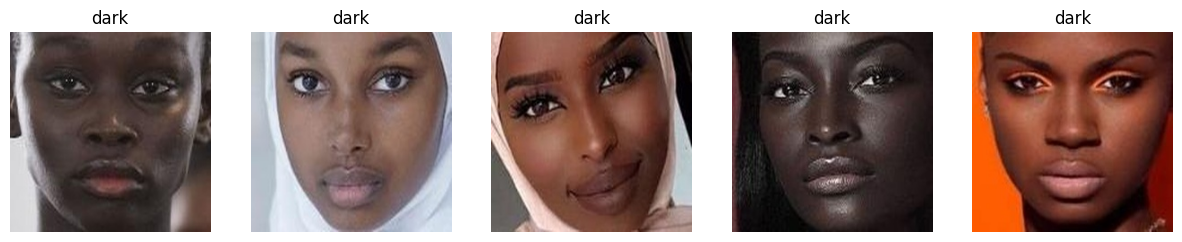

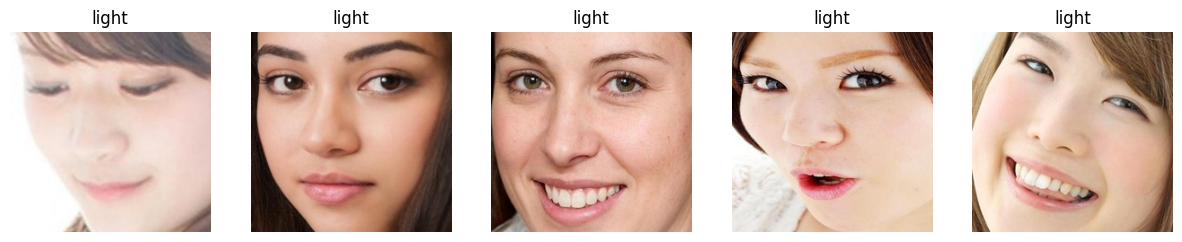

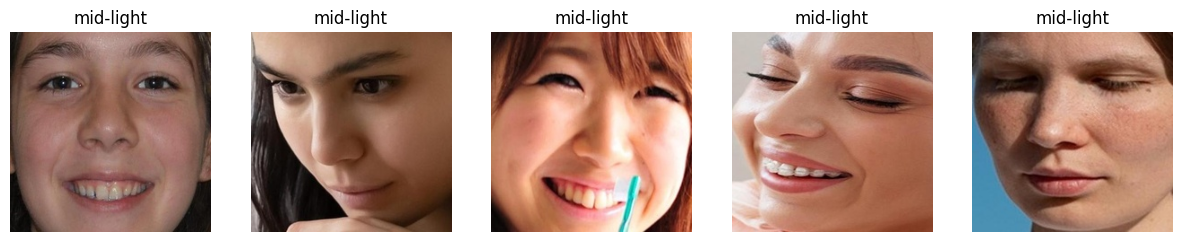

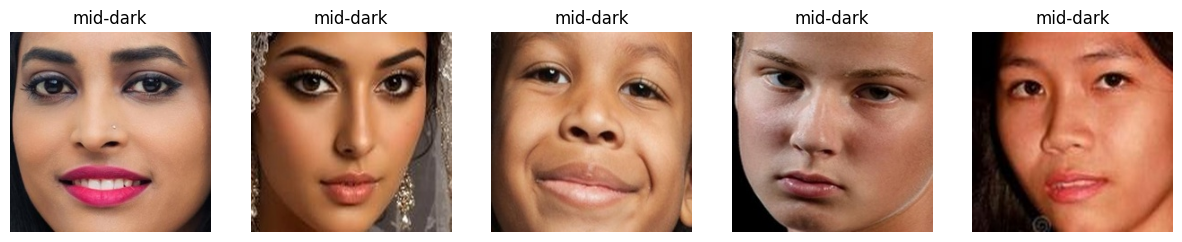

In [17]:
for skin_class in os.listdir(resized_dataset):
    show_samples(resized_dataset, skin_class)

In [18]:
# Cek Ukuran Gambar
sizes_df = check_image_sizes(resized_dataset)

        Width  Height
count  2921.0  2921.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


# **Undersampling**

In [19]:
def reduce_class_samples(source_dir, dest_dir, class_limits):
    """
    Menyalin maksimal N gambar dari tiap kelas ke folder baru secara acak,
    dan menghapus isi folder sebelumnya jika sudah ada.
    """
    print(f"\nMengurangi jumlah data dan menyalin ke folder baru: {dest_dir}")

    # Hapus folder tujuan jika sudah ada
    if os.path.exists(dest_dir):
        print("Folder sudah ada, menghapus isi sebelumnya...")
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    # Untuk reprodusibilitas
    random.seed(42)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        dest_class_path = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_path, exist_ok=True)

        all_images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        limit = class_limits.get(class_name, len(all_images))
        selected_images = random.sample(all_images, min(limit, len(all_images)))

        for img_name in selected_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(dest_class_path, img_name)
            shutil.copy2(src_path, dst_path)

        print(f"  - {class_name}: {len(selected_images)} gambar disalin (maks {limit})")

In [20]:
# Path tujuan (dataset hasil pengurangan)
reduced_dataset = './dataset-skin-tone_reduced'

# Batas jumlah gambar per kelas
class_limits = {
    'light': 668,
    'mid-light': 680,
    'dark': 539,
    'mid-dark': 650
}

# Jalankan reduksi
reduce_class_samples(resized_dataset, reduced_dataset, class_limits)


Mengurangi jumlah data dan menyalin ke folder baru: ./dataset-skin-tone_reduced
  - dark: 539 gambar disalin (maks 539)
  - light: 662 gambar disalin (maks 668)
  - mid-light: 680 gambar disalin (maks 680)
  - mid-dark: 650 gambar disalin (maks 650)


# **Data Splitting**

In [21]:
def split_dataset(source_dir, dest_dir, train_ratio=0.8):
    """
    Memisahkan dataset ke dalam folder 'train' dan 'val' dengan rasio tertentu.
    Membagi data secara stratified manual: membagi data dari setiap kelas satu per satu.
    """
    print(
        f"\nMembagi dataset dari {source_dir} ke dalam train/val "
        f"dengan rasio {int(train_ratio * 100)}/{int((1 - train_ratio) * 100)}..."
    )

    # Ambil semua nama folder kelas (diasumsikan satu kelas = satu folder)
    classes = [
        d for d in os.listdir(source_dir)
        if os.path.isdir(os.path.join(source_dir, d))
    ]

    # Buat struktur direktori tujuan: dest_dir/train/<kelas> dan dest_dir/val/<kelas>
    for split in ('train', 'val'):
        for cls in classes:
            os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)

    # Lakukan proses per kelas (stratifikasi manual)
    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        all_images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        random.shuffle(all_images)  # Mengacak urutan agar pembagian tidak bias

        # Hitung batas split sesuai rasio yang ditentukan
        split_index = int(len(all_images) * train_ratio)

        train_images = all_images[:split_index]
        val_images = all_images[split_index:]

        # Salin file ke folder masing-masing
        for split_name, images in [('train', train_images), ('val', val_images)]:
            print(f"  Processing class: {cls} ({split_name})")
            for img_name in tqdm(images, desc=f"    Copying {split_name} {cls}"):
                src = os.path.join(class_path, img_name)
                dst = os.path.join(dest_dir, split_name, cls, img_name)
                shutil.copy2(src, dst)  # copy2 mempertahankan metadata file

    print("\nPembagian dataset selesai.")

def count_images_in_folder(base_dir, split):
    """
    Menghitung jumlah gambar dalam folder 'train' dan 'val'.
    Menampilkan jumlah gambar per kelas.
    """
    path = os.path.join(base_dir, split)
    if not os.path.exists(path):
        print(f"Folder '{path}' tidak ditemukan.")
        return

    print(f"\nJumlah data di folder {split}:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            count = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            print(f"  - {cls}: {count} gambar")

In [22]:
split_dataset_path = './dataset-skin-tone_split'
split_dataset(reduced_dataset, split_dataset_path, train_ratio=0.8)

count_images_in_folder(split_dataset_path, 'train')
count_images_in_folder(split_dataset_path, 'val')


Membagi dataset dari ./dataset-skin-tone_reduced ke dalam train/val dengan rasio 80/19...
  Processing class: dark (train)


    Copying train dark: 100%|██████████| 431/431 [00:00<00:00, 5174.21it/s]


  Processing class: dark (val)


    Copying val dark: 100%|██████████| 108/108 [00:00<00:00, 7212.56it/s]


  Processing class: light (train)


    Copying train light: 100%|██████████| 529/529 [00:00<00:00, 5464.56it/s]


  Processing class: light (val)


    Copying val light: 100%|██████████| 133/133 [00:00<00:00, 4820.54it/s]


  Processing class: mid-light (train)


    Copying train mid-light: 100%|██████████| 544/544 [00:00<00:00, 4870.03it/s]


  Processing class: mid-light (val)


    Copying val mid-light: 100%|██████████| 136/136 [00:00<00:00, 4890.44it/s]


  Processing class: mid-dark (train)


    Copying train mid-dark: 100%|██████████| 520/520 [00:00<00:00, 4821.24it/s]


  Processing class: mid-dark (val)


    Copying val mid-dark: 100%|██████████| 130/130 [00:00<00:00, 4940.06it/s]


Pembagian dataset selesai.

Jumlah data di folder train:
  - dark: 431 gambar
  - light: 529 gambar
  - mid-light: 544 gambar
  - mid-dark: 520 gambar

Jumlah data di folder val:
  - dark: 108 gambar
  - light: 133 gambar
  - mid-light: 136 gambar
  - mid-dark: 130 gambar


In [23]:
!zip -r splitted-st-hijabist.zip ./dataset-skin-tone_split

  adding: dataset-skin-tone_split/ (stored 0%)
  adding: dataset-skin-tone_split/train/ (stored 0%)
  adding: dataset-skin-tone_split/train/dark/ (stored 0%)
  adding: dataset-skin-tone_split/train/dark/439_07d63ee4.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/021_2cc9b144.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/198_b16e1fef.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/86366378.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1222_c4d64010.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/242_a18a90f5.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1410_b3e1ba45.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1502_c971591e.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1559_fca23124.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/71736072.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1478_cac5f701.jpg (deflated 1%)
  adding:

## **Augmentasi Data Training**

In [9]:
def augment_images(train_dir, target_count):
    """
    Melakukan augmentasi gambar di folder train_dir agar setiap kelas memiliki
    jumlah gambar sebanyak target_count
    """

    # Konfigurasi ImageDataGenerator untuk augmentasi gambar.
    augmentor = ImageDataGenerator(
        rotation_range=10,        # Rotasi acak hingga 10 derajat.
        zoom_range=0.1,           # Zoom acak hingga 10%.
        horizontal_flip=True,     # Flip horizontal secara acak.
        fill_mode='nearest',      # Mode pengisian untuk area kosong pasca augmentasi.
    )

    # Loop untuk setiap folder kelas di direktori pelatihan
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Lewati jika bukan direktori (misalnya file README)

        # Ambil daftar gambar asli (tanpa 'aug' di nama file) di kelas ini
        images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 'aug' not in f.lower()
        ]
        current_count = len(images)  # Jumlah gambar asli saat ini

        # Jika jumlah gambar sudah mencukupi, lewati augmentasi untuk kelas ini
        if current_count >= target_count:
            print(f"Kelas '{class_name}' sudah cukup: {current_count}/{target_count}")
            continue

        needed = target_count - current_count  # Jumlah gambar yang perlu ditambahkan
        # Hitung jumlah augmentasi yang dibutuhkan per gambar
        per_image_aug_count = needed // len(images) if len(images) > 0 else 0
        # Tambahkan 1 augmentasi ekstra untuk sisa jika ada
        if len(images) > 0 and needed % len(images) != 0:
             per_image_aug_count += 1

        augmented_count = 0  # Counter jumlah augmentasi yang telah dibuat

        print(f"\nAugmentasi kelas {class_name} ({needed} gambar dibutuhkan):")

        with tqdm(total=needed, desc=f"Augmenting {class_name}", unit="images") as pbar:
            # Loop setiap gambar asli dan lakukan augmentasi
            for img_name in images:
                if augmented_count >= needed:
                    break  # Stop jika augmentasi sudah cukup

                img_path = os.path.join(class_path, img_name)
                try:
                    # Buka gambar dan ubah ke array
                    img = Image.open(img_path).convert('RGB')
                    img_array = np.expand_dims(np.array(img), axis=0)

                    i = 0  # Counter untuk jumlah augmentasi dari gambar ini

                    # Lakukan augmentasi menggunakan flow generator
                    for batch in augmentor.flow(
                        img_array,
                        batch_size=1,
                        save_to_dir=None,      # Kita simpan secara manual
                        save_format='jpg'
                    ):
                        # Buat nama file unik menggunakan UUID pendek
                        unique_id = uuid4().hex[:8]
                        new_filename = f"aug_{class_name}_{unique_id}.jpg"
                        save_path = os.path.join(class_path, new_filename)

                        # Simpan hasil augmentasi
                        Image.fromarray(batch[0].astype(np.uint8)).save(save_path, format='JPEG', quality=95)

                        i += 1
                        augmented_count += 1
                        pbar.update(1) # Update progress bar

                        # Hentikan augmentasi dari gambar ini jika sudah cukup
                        if i >= per_image_aug_count or augmented_count >= needed:
                            break

                except Exception as e:
                    # Tangani error pada gambar yang rusak atau tidak bisa dibuka
                    print(f"\nError pada {img_path}: {str(e)[:50]}")
                    pbar.set_description(f"Augmenting {class_name} (Error on {os.path.basename(img_path)})")


    # Cek akhir jumlah gambar per kelas setelah augmentasi
    final_count = {
        class_name: len([
            f for f in os.listdir(os.path.join(train_dir, class_name))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))
    }

    print("\nHasil akhir distribusi gambar:")
    for k, v in final_count.items():
        print(f"{k}: {v} gambar")

In [ ]:
train_dir = './dataset-skin-tone_split/train'
augment_images(train_dir, target_count=700)


Augmentasi kelas dark (269 gambar dibutuhkan):


Augmenting dark: 100%|██████████| 269/269 [00:03<00:00, 68.54images/s]



Augmentasi kelas light (166 gambar dibutuhkan):


Augmenting light: 100%|██████████| 166/166 [00:03<00:00, 41.83images/s]



Augmentasi kelas mid-light (156 gambar dibutuhkan):


Augmenting mid-light: 100%|██████████| 156/156 [00:03<00:00, 42.85images/s]



Augmentasi kelas mid-dark (180 gambar dibutuhkan):


Augmenting mid-dark: 100%|██████████| 180/180 [00:02<00:00, 73.33images/s]


Hasil akhir distribusi gambar:
dark: 700 gambar
light: 700 gambar
mid-light: 700 gambar
mid-dark: 700 gambar


Distribusi jumlah gambar per kelas: {'dark': 700, 'light': 700, 'mid-light': 700, 'mid-dark': 700}


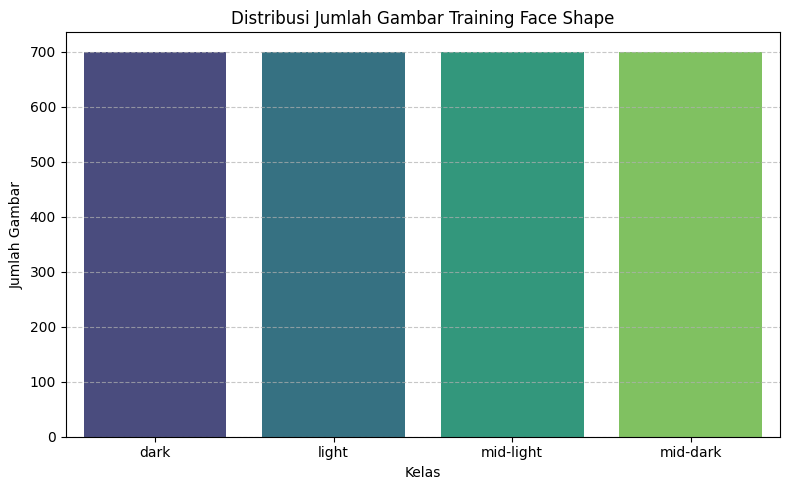

In [26]:
class_counts = count_images_per_class(train_dir)
print("Distribusi jumlah gambar per kelas:", class_counts)

# Visualisasi distribusi
plot_class_distribution(class_counts, title='Distribusi Jumlah Gambar Training Face Shape')


Menampilkan contoh gambar augmented per kelas:

Kelas 'dark': Menampilkan 5 gambar augmented.


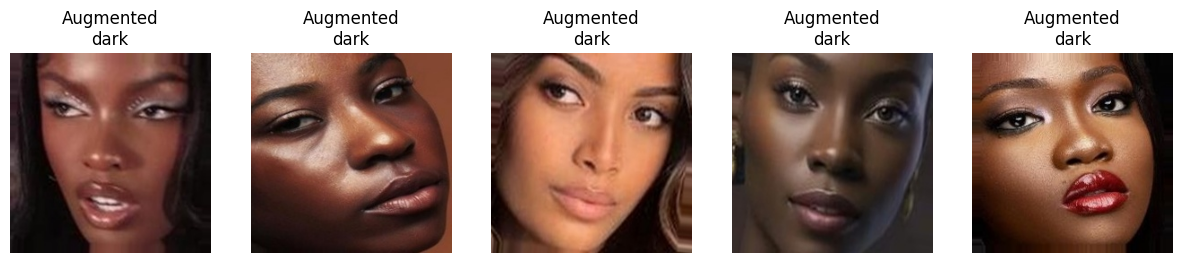


Kelas 'light': Menampilkan 5 gambar augmented.


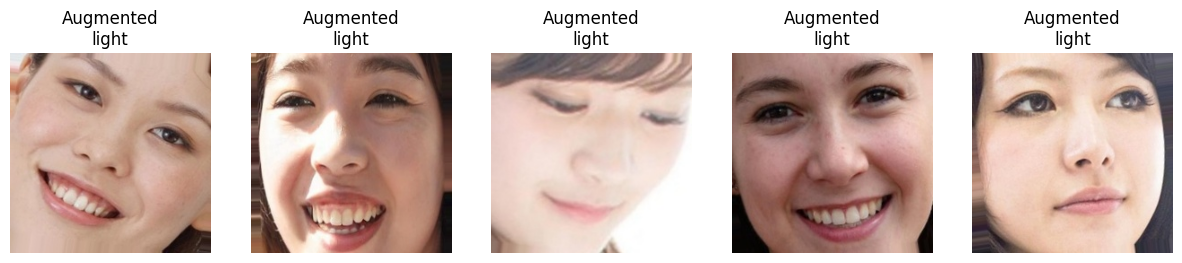


Kelas 'mid-light': Menampilkan 5 gambar augmented.


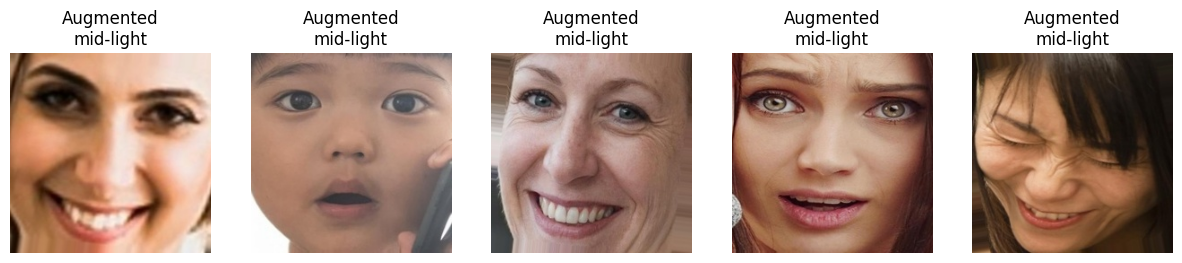


Kelas 'mid-dark': Menampilkan 5 gambar augmented.


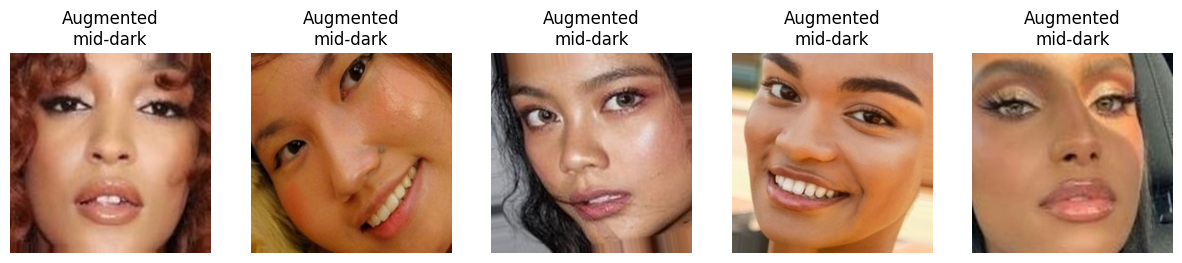

In [11]:
def show_augmented_samples_per_class(train_dir, n=5):
    """
    Menampilkan n gambar augmented pertama untuk setiap kelas dalam direktori train_dir.
    """
    classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    if not classes:
        print(f"Tidak ada subdirektori (kelas) ditemukan di {train_dir}")
        return

    print("\nMenampilkan contoh gambar augmented per kelas:")

    for class_name in classes:
        folder = os.path.join(train_dir, class_name)
        # Filter gambar yang namanya diawali dengan 'aug_'
        augmented_images = [
            f for f in os.listdir(folder)
            if f.lower().startswith('aug_') and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        if not augmented_images:
            print(f"\nTidak ada gambar augmented ditemukan di kelas '{class_name}'.")
            continue

        # Pilih n gambar pertama atau semua gambar jika jumlahnya kurang dari n
        images_to_show = augmented_images[:n]

        plt.figure(figsize=(15, 3))

        print(f"\nKelas '{class_name}': Menampilkan {len(images_to_show)} gambar augmented.")

        for i, img_file in enumerate(images_to_show):
            img_path = os.path.join(folder, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.subplot(1, len(images_to_show), i+1)
                plt.imshow(img)
                plt.title(f"Augmented\n{class_name}")
                plt.axis('off')
            except Exception as e:
                print(f"Gagal menampilkan gambar {img_file}: {e}")
        plt.show() # Tampilkan plot untuk kelas saat ini sebelum ke kelas berikutnya


# Panggil fungsi untuk menampilkan sampel augmented per kelas
show_augmented_samples_per_class(train_dir, n=5)

In [18]:
!zip -r aug-st-hijabist.zip ./dataset-skin-tone_split

  adding: dataset-skin-tone_split/ (stored 0%)
  adding: dataset-skin-tone_split/train/ (stored 0%)
  adding: dataset-skin-tone_split/train/dark/ (stored 0%)
  adding: dataset-skin-tone_split/train/dark/439_07d63ee4.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/aug_dark_d239e1c1.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/021_2cc9b144.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/aug_dark_2f1ed4cb.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/198_b16e1fef.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/313_ca50ca61.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/070_a74b30e6.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/86366378.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1222_c4d64010.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/242_a18a90f5.jpg (deflated 1%)
  adding: dataset-skin-tone_split/train/dark/1410_b3e1ba45.jpg (deflated 1%

# **Copy File to Gdrive**

In [ ]:
# Definisikan path ke file zip
files_to_copy = ["aug-st-hijabist.zip", "splitted-st-hijabist.zip"]

# Inisialisasi folder Google Drive
destination_folder = './drive/MyDrive/Hijabist-Drive/Skin-tone/Hijabist-dataset/'
os.makedirs(destination_folder, exist_ok=True)

# Salin setiap file zip ke Google Drive
for zip_file_path in files_to_copy:
  destination_path = os.path.join(destination_folder, os.path.basename(zip_file_path))
  try:
    shutil.copy(zip_file_path, destination_path)
    print(f"'{zip_file_path}' disalin ke '{destination_path}'")
  except FileNotFoundError:
    print(f"Error: '{zip_file_path}' tidak ditemukan.")
  except Exception as e:
    print(f"Terjadi error saat menyalin '{zip_file_path}': {e}")

'aug-st-hijabist.zip' disalin ke '/content/drive/MyDrive/Hijabist-Drive/Skin-tone/Hijabist-dataset/aug-st-hijabist.zip'
